# Read Files

In [1]:
import torch
from sklearn.model_selection import KFold
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import pandas as pd
from sklearn.metrics import roc_curve
sns.set_theme(style="darkgrid")



In [2]:
embeddings_file = '../data/LFW/embeddings_dict.pt'
pairs_file = '../data/LFW/original_pairs.txt'

embeddings_data = torch.load(embeddings_file, weights_only=True)

# Explore

In [3]:
for idx, key in enumerate(embeddings_data.keys()):
    if idx >= 5:
        break
    print(key, embeddings_data[key].shape)

Chris_Moore/Chris_Moore_0001.torch torch.Size([1, 512])
Robert_Towne/Robert_Towne_0001.torch torch.Size([1, 512])
Andy_Warhol/Andy_Warhol_0001.torch torch.Size([1, 512])
Tim_Conway/Tim_Conway_0002.torch torch.Size([1, 512])
Tim_Conway/Tim_Conway_0001.torch torch.Size([1, 512])


In [4]:
%%time
def l2_distance_torch(embedding1, embedding2):
    """Computes the L2 (Euclidean) distance between two embeddings."""
    return torch.linalg.vector_norm(embedding1 - embedding2).item()

keys = list(embeddings_data.keys())[:1000]
# Iterate over all embeddings and calculate the L2 distance with all other embeddings
distances = []
for i in tqdm(range(len(keys))):
    for j in range(i+1, len(keys)):
        embedding2 = embeddings_data[keys[j]]
        embedding1 = embeddings_data[keys[i]]
        distance = l2_distance_torch(embedding1, embedding2)
        distances.append(distance)

100%|██████████| 1000/1000 [00:01<00:00, 502.20it/s]

CPU times: user 1.98 s, sys: 14.9 ms, total: 2 s
Wall time: 1.99 s


<Axes: ylabel='Count'>

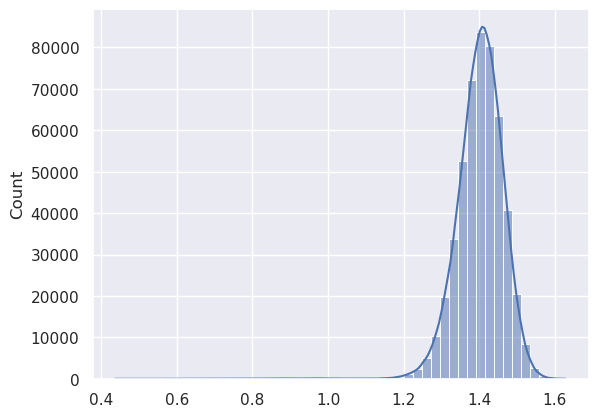

In [5]:
# Plot using seaborn library a histogram of the distances
sns.histplot(distances, bins=50, kde=True)

# K Fold

## Read pairs

In [6]:

def load_pairs_from_original_file(pair_file_path):
    """Loads pairs from the original file and converts them into correct embedding format."""
    pairs = []
    with open(pair_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()

            if len(parts) == 3:  # Format: Person_Name 1 2 (two images of the same person)
                person_name, num1, num2 = parts
                # Convert to the required format for embedding names
                img1_name = f'{person_name}/{person_name}_{num1.zfill(4)}.torch'
                img2_name = f'{person_name}/{person_name}_{num2.zfill(4)}.torch'
                pairs.append((img1_name, img2_name, 1))  # These are same person pairs

            elif len(parts) == 4:  # Format: Person1_Name 1 Person2_Name 1 (two images of different people)
                person1_name, num1, person2_name, num2 = parts
                # Convert to the required format for embedding names
                img1_name = f'{person1_name}/{person1_name}_{num1.zfill(4)}.torch'
                img2_name = f'{person2_name}/{person2_name}_{num2.zfill(4)}.torch'
                pairs.append((img1_name, img2_name, 0))  # These are different person pairs

    return pairs
pairs = load_pairs_from_original_file(pairs_file)


## Get K folds

In [7]:
# Calculate accuracy given a threshold using numpy
def calculate_accuracy(distances, ground_truth, threshold):
    """Calculates the accuracy given a threshold."""
    predictions = (distances < threshold).astype(int)
    accuracy = (predictions == ground_truth).astype(float).mean()
    return accuracy

# Calculate the optimal threshold for the given distances and ground truth
def optimal_threshold(distances, ground_truth):
    """
    Calculate the optimal threshold for a binary classification problem using the ROC curve and Youden's J statistic.

    Parameters:
    distances (list or numpy array): The predicted distances or probabilities for the positive class.
    ground_truth (list or numpy array): The ground truth binary labels (0 or 1).

    Returns:
    float: The optimal threshold value that maximizes Youden's J statistic.

    Notes:
    - The function assumes that the positive class is labeled as 0.
    - The ROC curve is calculated using the `roc_curve` function from the `sklearn.metrics` module.
    - Youden's J statistic is defined as `tpr - fpr`, where `tpr` is the true positive rate and `fpr` is the false positive rate.
    """
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve( (np.array(ground_truth).astype(int)), distances, pos_label=0)

    # Calculate Youden's J statistic
    youden_j = tpr - fpr

    # Find the optimal threshold
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold


accuracies = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for test_index, train_index in kf.split(pairs):
    train = np.array(pairs)[train_index]
    test = np.array(pairs)[test_index]
    
    distances_train = np.array([l2_distance_torch(embeddings_data[a], embeddings_data[b]) for a,b,_ in train])
    ground_truth_train = np.array([gt for _,_,gt in train]).astype(int)
    distances_test = np.array([l2_distance_torch(embeddings_data[a], embeddings_data[b]) for a,b,_ in test])
    ground_truth_test = np.array([gt for _,_,gt in test]).astype(int)

    threshold = optimal_threshold(distances_train, ground_truth_train)
    accuracies.append(calculate_accuracy(distances_test, ground_truth_test, threshold))
    
print(f'Mean accuracy: {np.mean(accuracies):.5f}')

Mean accuracy: 0.99117


# Some Graphs to understand the treshold

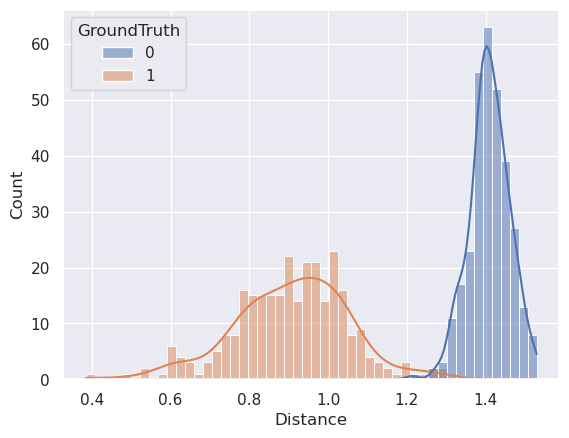

In [8]:
train = np.array(pairs)[train_index]
test = np.array(pairs)[test_index]

distances = np.array([l2_distance_torch(embeddings_data[a], embeddings_data[b]) for a,b,_ in train])
ground_truth = np.array([gt for _,_,gt in train]).astype(int)

# Plot using seaborn library a histogram of the distances using ground truth as hue
# Create a dataframe of distances and ground truth
df = pd.DataFrame({'Distance': distances, 'GroundTruth': ground_truth})

# Plot using seaborn library a histogram of the distances using ground truth as hue
sns.histplot(data=df, x='Distance', hue='GroundTruth', bins=50, kde=True)
plt.show()

In [9]:
threshold_calculated = optimal_threshold(distances, ground_truth)
print(f'Optimal threshold: {threshold_calculated}')

Optimal threshold: 1.2712717056274414


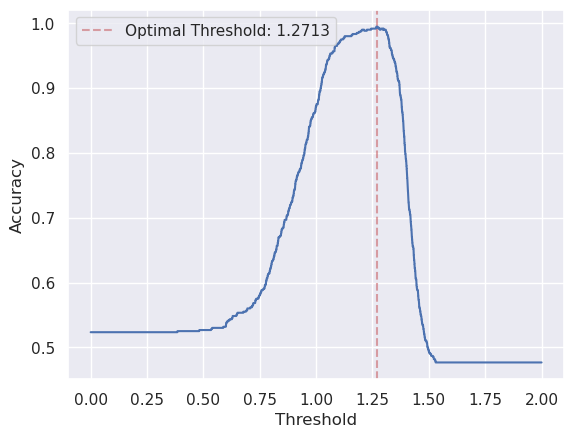

In [10]:

# graph 10000 linearly distributed thresholds between 0 and 2 and calculate accuracy for each
thresholds = np.linspace(0, 2, 10000)
accuracies = []
for threshold in thresholds:
    accuracies.append(calculate_accuracy(distances, ground_truth, threshold))

# Plot the accuracy vs threshold using pandas and seaborn
df = pd.DataFrame({'Threshold': thresholds, 'Accuracy': accuracies})
sns.set_theme()
sns.lineplot(data=df, x='Threshold', y='Accuracy')
plt.axvline(x=threshold_calculated, color='r', linestyle='--', alpha=0.5, label=f'Optimal Threshold: {threshold_calculated:.4f}')
plt.legend()
plt.show()